# Little's Law simulation

Little's Law for open systems:

$$ E[N] = \lambda E[T] $$

where

- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)

In [96]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [97]:
rng = np.random.default_rng(42)

In [98]:
num_events = 5000

## 1 Arrival times 

In [99]:
mean_arrival_rate = 16.0  # this is lambda
mean_interarrival_time = 1.0 / mean_arrival_rate
num_bins_arrival = int(num_events / mean_arrival_rate)

In [100]:
interarrival_times = rng.exponential(scale=mean_interarrival_time, size=num_events)

In [101]:
interarrival_times[0:15]

array([0.15026304, 0.14601185, 0.14904756, 0.01748714, 0.00540234,
       0.09079128, 0.08812254, 0.1952685 , 0.00495589, 0.06541005,
       0.00440227, 0.06806398, 0.10820796, 0.02418093, 0.0769741 ])

In [102]:
print(f"mean_interarrival_time_actual   ={mean_interarrival_time}")
print(f"mean_interarrival_time_observed ={np.mean(interarrival_times)}")

mean_interarrival_time_actual   =0.0625
mean_interarrival_time_observed =0.06148502588802146


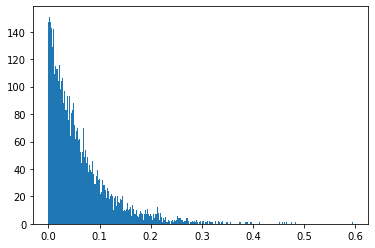

In [103]:
plt.hist(interarrival_times, bins=num_bins_arrival)
plt.show()

In [104]:
arrival_times = np.cumsum(interarrival_times)

In [105]:
arrival_times.shape

(5000,)

In [106]:
arrival_times[0:100]

array([0.15026304, 0.29627489, 0.44532245, 0.4628096 , 0.46821193,
       0.55900322, 0.64712576, 0.84239426, 0.84735014, 0.9127602 ,
       0.91716247, 0.98522644, 1.0934344 , 1.11761533, 1.19458943,
       1.20420026, 1.20992384, 1.22962254, 1.2859475 , 1.31175908,
       1.3897207 , 1.40369422, 1.51856737, 1.59526023, 1.63624749,
       1.66231541, 1.69064789, 1.69546521, 1.70669223, 1.74952476,
       1.77381727, 1.8528302 , 1.89711086, 1.91198149, 1.94079951,
       1.9808968 , 2.00238639, 2.02250584, 2.07743801, 2.09599721,
       2.17935361, 2.26628261, 2.33403779, 2.33860206, 2.40948128,
       2.49412741, 2.56425489, 2.58175796, 2.60181647, 2.61217496,
       2.63432268, 2.63564392, 2.64610369, 2.72829474, 2.97802951,
       3.01325064, 3.03100312, 3.05586289, 3.07844678, 3.08654888,
       3.1542567 , 3.24024725, 3.33448532, 3.666353  , 3.79801926,
       3.90082338, 3.96604159, 4.00307436, 4.0058527 , 4.06564038,
       4.10447682, 4.19872441, 4.32547451, 4.34622881, 4.34933

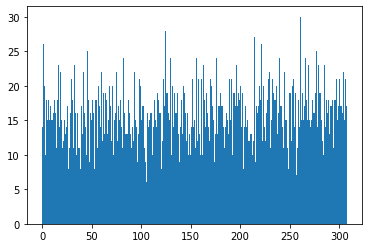

In [107]:
counts, bins, bars = plt.hist(arrival_times, bins=num_bins_arrival)
plt.show()

In [108]:
np.mean(counts)

16.025641025641026

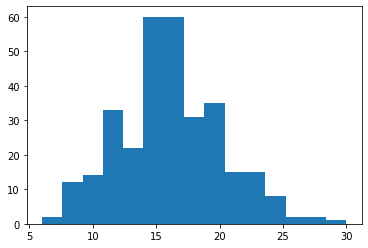

In [109]:
plt.hist(counts, bins=15)
plt.show()

## 2 Service times 

In [110]:
mean_service_rate = 20.0  # mu = 1 / E[S]
mean_service_time = 1.0 / mean_service_rate  # E[S]
num_bins_service = int(num_events / mean_service_rate)

In [111]:
service_times = rng.exponential(scale=mean_service_time, size=num_events)

In [112]:
service_times[0:15]

array([0.00158195, 0.01884807, 0.09045764, 0.07635791, 0.08590009,
       0.04994925, 0.01101017, 0.07612617, 0.0985673 , 0.09991621,
       0.08083917, 0.05350831, 0.11389655, 0.07927393, 0.00350595])

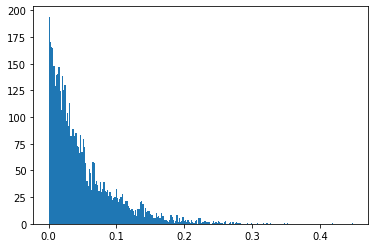

In [113]:
plt.hist(service_times, bins=num_bins_service)
plt.show()

## 3 Simulation 

We'll run the "jobs" through the system, estimate both $E[N]$ and $E[T]$, and compare the result to Little's Law.

In [114]:
df = pd.DataFrame({
    "arrival_time": arrival_times,
    "service_time": service_times,
    "start_time": np.zeros(num_events),
    "end_time": np.zeros(num_events)
})

In [115]:
df.loc[0, "start_time"] = df.loc[0, "arrival_time"]
df.loc[0, "end_time"] = df.loc[0, "start_time"] + df.loc[0, "service_time"]

In [116]:
for i in range(1, num_events):
    df.loc[i, "start_time"] = max(df.loc[i, "arrival_time"], df.loc[i-1, "end_time"])
    df.loc[i, "end_time"] = df.loc[i, "start_time"] + df.loc[i, "service_time"]

In [117]:
df["response_time"] = df["end_time"] - df["arrival_time"]

In [118]:
df.head(20)

,arrival_time,service_time,start_time,end_time,response_time
0,0.150263,0.001582,0.150263,0.151845,0.001582
1,0.296275,0.018848,0.296275,0.315123,0.018848
2,0.445322,0.090458,0.445322,0.535780,0.090458
3,0.462810,0.076358,0.535780,0.612138,0.149328
4,0.468212,0.085900,0.612138,0.698038,0.229826
5,0.559003,0.049949,0.698038,0.747987,0.188984
6,0.647126,0.011010,0.747987,0.758998,0.111872
7,0.842394,0.076126,0.842394,0.918520,0.076126
8,0.847350,0.098567,0.918520,1.017088,0.169738
9,0.912760,0.099916,1.017088,1.117004,0.204244


In [119]:
mean_response_time = df["response_time"].mean()

In [120]:
mean_response_time

0.26122913073546106

In [121]:
# Build intervals and their corresponding job counts so we can calculate E[N].
# To do this, we will have two pointers: one for the arrival times and the other for the end (departure) times.
# At each iteration, the lower-valued pointer is the next interval's upper bound. We increment the job count
# whenever we choose the arrival time and we decrement the job count whenever we choose the end time.
intervals_df = pd.DataFrame(columns=["start_time", "end_time", "width", "num_jobs"])

lo_bd = 0.0
arrival_idx = 0
end_idx = 0
num_jobs = 0
while arrival_idx < num_events and end_idx < num_events:
    curr_arrival = df.loc[arrival_idx, "arrival_time"]
    curr_end = df.loc[end_idx, "end_time"]
    if curr_arrival < curr_end:
        num_jobs = num_jobs + 1
        up_bd = curr_arrival
        arrival_idx = arrival_idx + 1
    else:
        num_jobs = num_jobs - 1
        up_bd = curr_end
        end_idx = end_idx + 1
    
    width = up_bd - lo_bd
    intervals_df = intervals_df.append({
        "start_time": lo_bd,
        "end_time": up_bd,
        "width": width,
        "num_jobs": num_jobs,
        "weighted_num_jobs": width * num_jobs
    }, ignore_index=True)
    
    lo_bd = up_bd

In [122]:
intervals_df.head(20)

,start_time,end_time,width,num_jobs,weighted_num_jobs
0,0.000000,0.150263,0.150263,1.0,0.150263
1,0.150263,0.151845,0.001582,0.0,0.000000
2,0.151845,0.296275,0.144430,1.0,0.144430
3,0.296275,0.315123,0.018848,0.0,0.000000
4,0.315123,0.445322,0.130199,1.0,0.130199
5,0.445322,0.462810,0.017487,2.0,0.034974
6,0.462810,0.468212,0.005402,3.0,0.016207
7,0.468212,0.535780,0.067568,2.0,0.135136
8,0.535780,0.559003,0.023223,3.0,0.069669
9,0.559003,0.612138,0.053135,2.0,0.106270


In [123]:
total_weighted_num_jobs = intervals_df["weighted_num_jobs"].sum()
total_weighted_num_jobs

1343.5601265393905

In [124]:
total_width = intervals_df["width"].sum()
total_width

307.4251294401077

In [125]:
mean_num_jobs = total_weighted_num_jobs / total_width
mean_num_jobs

4.37036532760456

In [126]:
# Little's Law verification
mean_arrival_rate * mean_response_time

4.179666091767377